In [1]:
import pandas as pd
import numpy as np
import treeswift # please cite https://github.com/niemasd/TreeSwift 
from queue import PriorityQueue,Queue
from tqdm.notebook import trange, tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# these functions were grabbed from https://github.com/niemasd/TreeCluster/blob/master/TreeCluster.py
# please cite this paper if you use this script 
def root_dist(tree,threshold,support):
    leaves = prep(tree,support)
    clusters = list()
    for node in tree.traverse_preorder():
        # if I've already been handled, ignore me
        if node.DELETED:
            continue
        if node.is_root():
            node.root_dist = 0
        else:
            node.root_dist = node.parent.root_dist + node.edge_length
        if node.root_dist > threshold:
            cluster = cut(node)
            if len(cluster) != 0:
                clusters.append(cluster)
                for leaf in cluster:
                    leaves.remove(leaf)

    # add all remaining leaves to a single cluster
    if len(leaves) != 0:
        clusters.append(list(leaves))
    return clusters
# initialize properties of input tree and return set containing taxa of leaves
def prep(tree, support, resolve_polytomies=True, suppress_unifurcations=True):
    if resolve_polytomies:
        tree.resolve_polytomies()
    if suppress_unifurcations:
        tree.suppress_unifurcations()
    leaves = set()
    for node in tree.traverse_postorder():
        if node.edge_length is None:
            node.edge_length = 0
        node.DELETED = False
        if node.is_leaf():
            leaves.add(str(node))
        else:
            try:
                node.confidence = float(str(node))
            except:
                node.confidence = 100. # give edges without support values support 100
            if node.confidence < support: # don't allow low-support edges
                node.edge_length = float('inf')
    return leaves
def cut(node):
    cluster = list()
    descendants = Queue(); descendants.put(node)
    while not descendants.empty():
        descendant = descendants.get()
        if descendant.DELETED:
            continue
        descendant.DELETED = True
        descendant.left_dist = 0; descendant.right_dist = 0; descendant.edge_length = 0
        if descendant.is_leaf():
            cluster.append(str(descendant))
        else:
            for c in descendant.children:
                descendants.put(c)
    return cluster

In [3]:
tree = treeswift.read_tree_nexus('./Phenuiviridae.tree')
annot = pd.read_table('./Phenuiviridae.tsv', header=None)
annot[3] = annot[1] + '_'+ annot[0] #create leaf lables
annot.columns = ['seqid','annot_1','annot_2', 'leaf_lab']
#clust = root_dist(tree['tree_1'], 4, 1 ) #get distance based clusters

In [4]:
#get all internal nodes from a tree. consider each branch as a cluster
clust_n = 0
clust_leaf = []
for branch in tree['tree_1'].traverse_postorder():
       if not branch.is_leaf():
            tmp_ = []
            for leaf in branch.traverse_leaves():
                tmp_.append([clust_n,str(leaf)])
            if len(tmp_) > 10: #extract all branches with more than n leaves
                #print(len(tmp_))
                clust_leaf.extend(tmp_)
                clust_n += 1

In [5]:
clust_leaf=pd.DataFrame(clust_leaf)
clust_leaf.columns = ['cluster', 'leaf_lab']

In [6]:
annot = pd.merge(clust_leaf,annot,
                 right_on='leaf_lab', 
                 left_on='leaf_lab') #add annotations to clusters

In [13]:
column = 'annot_2' #only chnage this colum 
#column2 = 'tmp' #simulation output is saved here

In [17]:
tmp = annot.groupby('cluster')[column].value_counts().sort_index()
tmp = pd.DataFrame(tmp)
tmp.columns = ['counts']
tmp.reset_index(inplace=True)
sum_cluster = tmp.groupby('cluster').sum(numeric_only=True)
max_per_cluster = tmp.groupby('cluster').max()
observed_difference_in_nps=sum(max_per_cluster['counts'])/sum(sum_cluster['counts']) #cluster purity https://stats.stackexchange.com/questions/95731/how-to-calculate-purity
observed_difference_per_cluster = np.array(max_per_cluster['counts']/sum_cluster['counts'])

In [18]:
print(f"global cluster purity: {observed_difference_in_nps : .2f}")

global cluster purity:  0.12


In [19]:
#simulation
simulated = []
simulated_per_group = []
for _ in trange(1000):
    annot['tmp'] = annot[column].sample(frac=1).values
    tmp2 = annot.groupby('cluster')['tmp'].value_counts().sort_index()
    tmp2 = pd.DataFrame(tmp2)
    tmp2.columns = ['counts']
    tmp2.reset_index(inplace=True)
    sum_cluster2 = tmp2.groupby('cluster').sum(numeric_only=True)
    max_per_cluster2 = tmp2.groupby('cluster').max()
    simulated_per_group.append(max_per_cluster2['counts']/sum_cluster2['counts'])
    simulated.append(sum(max_per_cluster2['counts'])/sum(sum_cluster2['counts']))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
simulated_results_per_cluster = np.array(simulated_per_group)

In [21]:
print(f"average cluster purity (permuted) : { np.mean(simulated):.2f} {u'±'}{np.std(simulated) : .2f}")

average cluster purity (permuted) : 0.13 ± 0.00


### percluster significance (permuted)

In [22]:
significance_level = 0.05

simulations_greater_than_observed_cluster= sum(
    simulated_results_per_cluster >= observed_difference_per_cluster
)
num_simulations_cluster = simulated_results_per_cluster.shape[0]
p_value = simulations_greater_than_observed_cluster / num_simulations_cluster
# Boolean which is True if significant, False otherwise
significant_or_not_cluster = p_value < significance_level

In [23]:
per_clust = pd.DataFrame(zip(np.arange(significant_or_not_cluster.shape[0]),significant_or_not_cluster,p_value, annot['cluster'].value_counts().sort_index().to_list()))
per_clust.columns = ['clusters','is_significant','p_value','cluster_size']

In [28]:
per_clust.query('is_significant == True')

,clusters,is_significant,p_value,cluster_size
23,23,True,0.038,32
24,24,True,0.018,33
25,25,True,0.025,37
313,313,True,0.014,14
314,314,True,0.009,17
315,315,True,0.039,21


In [30]:
annot.query('cluster == 25')

,cluster,leaf_lab,seqid,annot_1,annot_2,tmp
2752,25,Bandavirus_ATW62985.1,ATW62985.1,Bandavirus,654,522
2820,25,Bandavirus_ATW62994.1,ATW62994.1,Bandavirus,9855,522
2888,25,Bandavirus_ATW62991.1,ATW62991.1,Bandavirus,6587,1771
2956,25,Bandavirus_ATW62992.1,ATW62992.1,Bandavirus,1771,1771
3024,25,Bandavirus_ATW62983.1,ATW62983.1,Bandavirus,9855,2346
3092,25,Bandavirus_ATW62989.1,ATW62989.1,Bandavirus,9,2346
3160,25,Bandavirus_AGM33037.1,AGM33037.1,Bandavirus,234,654
3228,25,Bandavirus_AGM33041.1,AGM33041.1,Bandavirus,9855,234
3296,25,Phlebovirus_AFN26689.1,AFN26689.1,Phlebovirus,56763,522
3364,25,Bandavirus_AMY99360.1,AMY99360.1,Bandavirus,45437,9855


#### Global cluster purity (permuted)

In [25]:
simulated_results=np.array(simulated)

In [26]:
significance_level = 0.05

simulations_greater_than_observed= sum(
    simulated_results >= observed_difference_in_nps
)
num_simulations = simulated_results.shape[0]
p_value = simulations_greater_than_observed / num_simulations
significant_or_not = p_value < significance_level

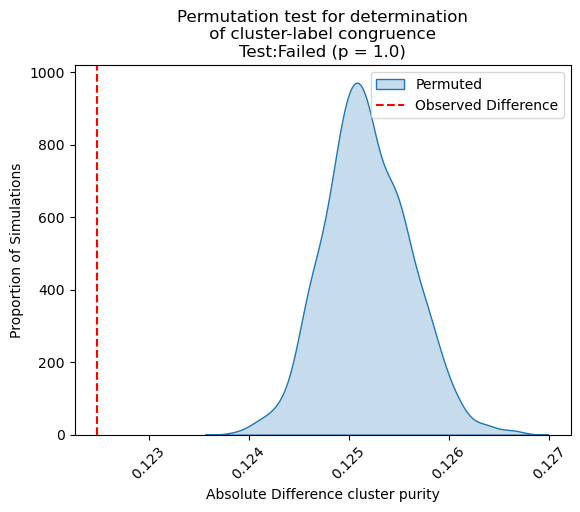

In [27]:
# Plot permutation simulations
density_plot = sns.kdeplot(simulated, fill=True, label='Permuted')
density_plot.set(
    xlabel='Absolute Difference cluster purity',
    ylabel='Proportion of Simulations',
    title=f'Permutation test for determination\n of cluster-label congruence \n{ "Test: Passed" if significant_or_not else "Test:Failed"} (p = {p_value})'
    
)

# Add a line to show the actual difference observed in the data
density_plot.axvline(
    x=observed_difference_in_nps, 
    color='red', 
    linestyle='--',
    label = 'Observed Difference'
)

plt.legend(
    loc='upper right'
)
plt.xticks(rotation=45)
#plt.savefig('./test_failed.png')
plt.show()